# Week4: Calibration，Single view metrology， Photometric image formation

This week, we build on our understanding of camera models by examining calibration and single-view metrology, learning how to determine camera parameters, address lens distortions, and infer scene geometry from a single image. We then turn to photometric image formation and reflectance models, exploring how light, surface properties, and material characteristics shape the intensity values captured by a camera. These combined insights set the stage for more advanced methods like photometric stereo and refined 3D reconstruction.

In this section, we will learn about:

- types of distortion caused by cameras
- how to find the intrinsic and extrinsic properties of a camera
- how to undistort images based off these properties

Ref: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

#### 1. Please complete the following coding tasks, and then proceed to answer the three questions.

#### 2. Provide written answers to the reflection questions in the Markdown cells below each question.

#### 3. Submit the final .ipynb file.

Pinhole cameras often distort images through radial and tangential distortions. Correcting these requires understanding the camera's intrinsic parameters (like focal length and optical centers) and extrinsic parameters (orientation and position). Intrinsic parameters help form a camera matrix, a 3x3 matrix crucial for correcting lens distortions. This matrix is unique to each camera and, once computed, can correct any image taken by that camera.

Let get started!

For camera calibration with OpenCV, we need images of a chessboard. Calibration requires matching 3D real world points to 2D image points. The latter, found where chessboard squares meet, is straightforward to identify. Assuming the chessboard is fixed on the XY plane (Z=0), we simplify to finding just the X,Y coordinates. These can be set as (0,0), (1,0), (2,0), etc., reflecting the chessboard squares' positions, with results scaled by square size. Without knowing the exact square size, we use relative square dimensions, referring to these 3D and 2D points as object and image points, respectively.

To detect chessboard patterns, use cv.findChessboardCorners(), specifying the grid size (e.g., 7x6 for this example). The function returns corner points and a boolean indicating pattern detection success.

In [2]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

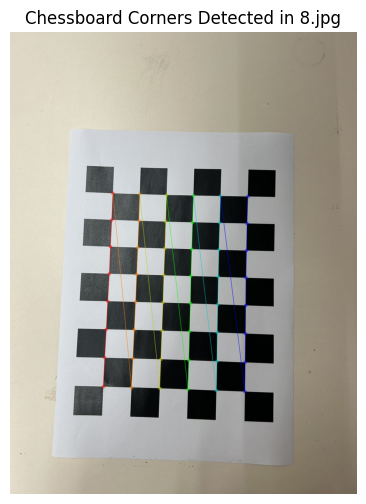

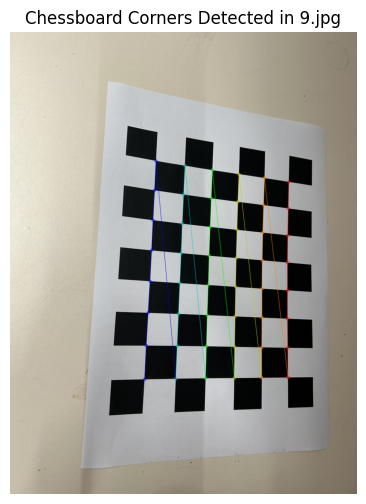

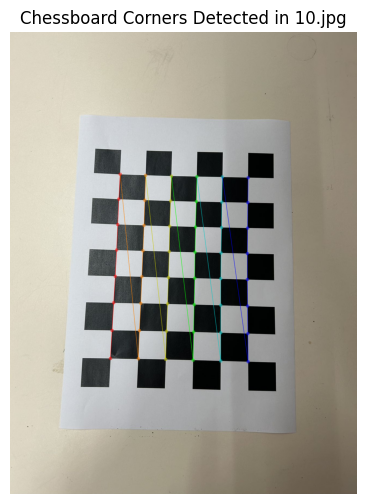

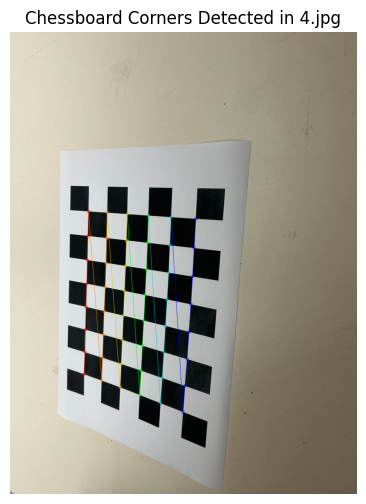

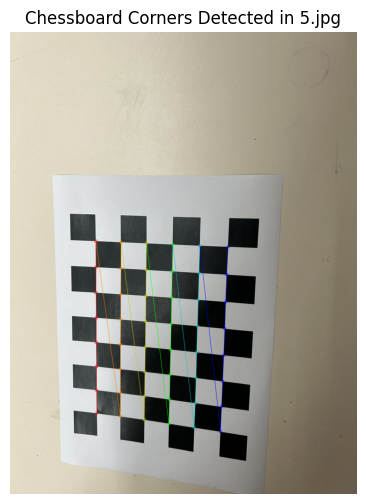

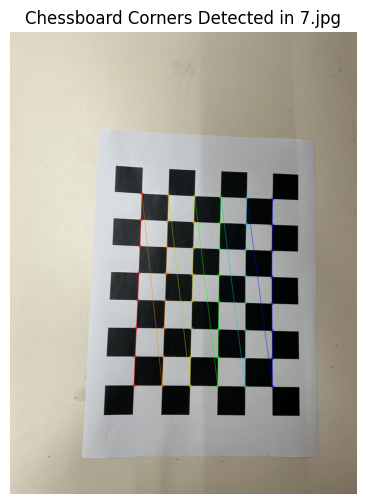

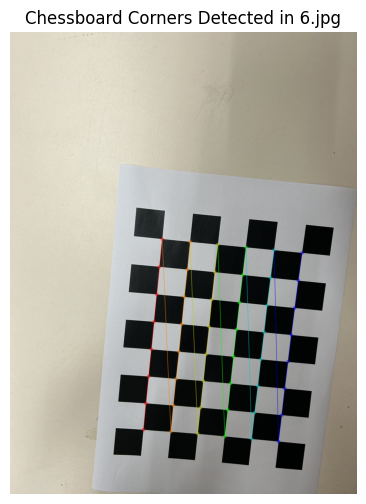

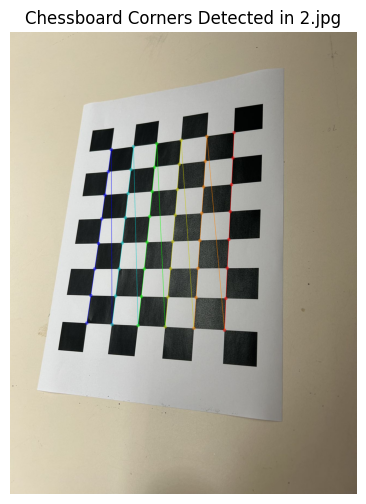

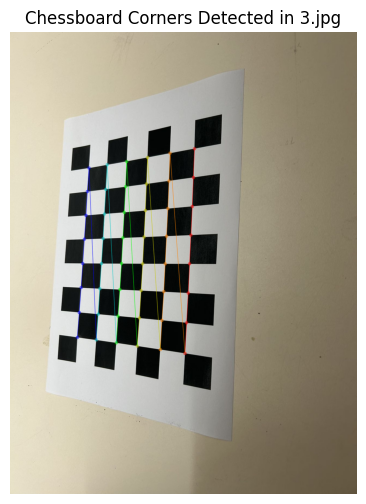

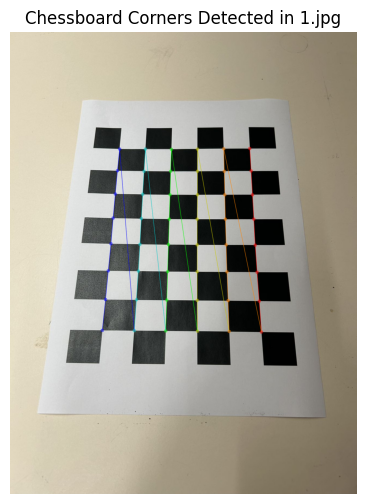

In [4]:
# Criteria for corner refinement (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, epsilon)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points for a 6x8 chessboard pattern (adjust if using a different pattern)
chessboard_size = (8, 6)  # (columns, rows)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

# Arrays to store object points and image points from all images
objpoints = []  # 3D points in real-world space
imgpoints = []  # 2D points in the image plane

# Provide the correct path to your folder containing chessboard images
images = glob.glob('./demo/camera_calibration/*.jpg')

for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Attempt to find the chessboard corners
    ret, corners = cv.findChessboardCorners(gray, chessboard_size, None)
    
    if ret:
        objpoints.append(objp)
        
        # Refine the corner positions
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        
        # Draw the corners on the image
        cv.drawChessboardCorners(img, chessboard_size, corners2, ret)
        
        # Convert the image to RGB for matplotlib display
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        # Display the image with the detected corners
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.title(f"Chessboard Corners Detected in {fname.split('/')[-1]}")
        plt.axis('off')
        plt.show()

# After processing, you can attempt camera calibration using cv.calibrateCamera
# (Not shown here, but after collecting objpoints and imgpoints, you can call:
# ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

plt.close('all')

## Calibration
Now that we have our object points and image points, we are ready to go for calibration. We can use the function, cv.calibrateCamera() which returns the camera matrix, distortion coefficients, rotation and translation vectors etc.



In [5]:
# Fill you code here, by using: cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Camera Matrix:")
print(mtx)
print("\nDistortion Coefficients:")
print(dist)
print("\nRotation Vectors:")
print(rvecs)
print("\nTranslation Vectors:")
print(tvecs)

Camera Matrix:
[[1.26821950e+03 0.00000000e+00 6.34090311e+02]
 [0.00000000e+00 1.26996240e+03 8.58605649e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
[[ 2.90253622e-01 -1.31014603e+00 -3.67472999e-03 -7.92456616e-04
   2.18088283e+00]]

Rotation Vectors:
(array([[-0.08201737],
       [-0.04936007],
       [-1.54008145]]), array([[-0.32390515],
       [-0.12870723],
       [ 1.61723549]]), array([[-0.10563561],
       [-0.11462659],
       [-1.54284459]]), array([[-0.31979935],
       [ 0.49954773],
       [-1.43435368]]), array([[-0.04799383],
       [ 0.27185577],
       [-1.52296259]]), array([[-0.02491049],
       [-0.13128839],
       [-1.53853204]]), array([[ 0.08584257],
       [ 0.03352237],
       [-1.46975709]]), array([[0.05263234],
       [0.46982634],
       [1.57866346]]), array([[0.34454891],
       [0.48045648],
       [1.55673562]]), array([[-0.27268612],
       [ 0.30465668],
       [ 1.56329188]]))

Translation Vectors:
(array([[-2.

## Undistortion
Now, we can take an image and undistort it. OpenCV comes with two methods for doing this. 

However first, we can refine the camera matrix based on a free scaling parameter using cv.getOptimalNewCameraMatrix(). If the scaling parameter alpha=0, it returns undistorted image with minimum unwanted pixels. So it may even remove some pixels at image corners. If alpha=1, all pixels are retained with some extra black images. This function also returns an image ROI which can be used to crop the result.

So, we take a new image (a.jpg in this case. That is the first image in this chapter)

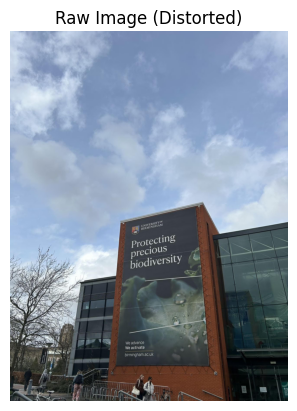

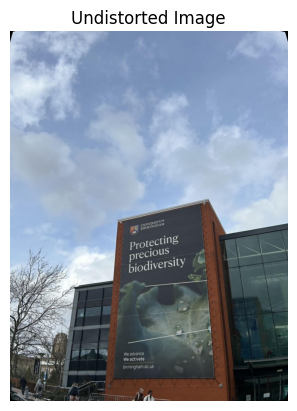

In [6]:
# Assume we have obtained camera matrix (mtx) and distortion coefficients (dist)
# from a previous calibration step. The student should have mtx, dist from calibrateCamera.

# Load the distorted image
img = cv.imread('./demo/a.jpg')  # Modify the path if needed
h, w = img.shape[:2]

# Refine the camera matrix based on a free scaling parameter
alpha = 0.5  # Experiment with values between 0.0 and 1.0
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), alpha, (w, h))

# Convert the image to RGB for matplotlib display
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.title('Raw Image (Distorted)')
plt.axis('off')
plt.show()
plt.close('all')

#######################################
# Undistortion
#######################################
# Using newcameramtx and dist to undistort the image
undistorted = cv.undistort(img, mtx, dist, None, newcameramtx)
undistorted_rgb = cv.cvtColor(undistorted, cv.COLOR_BGR2RGB)

plt.imshow(undistorted_rgb)
plt.title('Undistorted Image')
plt.axis('off')
plt.show()
plt.close('all')

### 1. Using <strong>cv.undistort()</strong>
This is the easiest way. Just call the function and use ROI obtained above to crop the result.

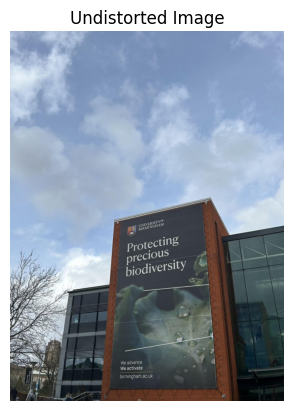

In [7]:
#######################################
# Undistortion
#######################################
# Using newcameramtx and dist to undistort the image
undistorted = cv.undistort(img, mtx, dist, None, newcameramtx)

# Crop the image using ROI
x, y, w, h = roi
undistorted = undistorted[y:y+h, x:x+w]

# Convert to RGB for display
dst_rgb = cv.cvtColor(undistorted, cv.COLOR_BGR2RGB)

plt.imshow(dst_rgb)
plt.title('Undistorted Image')
plt.axis('off')
plt.show()
plt.close('all')

### 2. Using <strong>remapping</strong>
This way is a little bit more difficult. First, find a mapping function from the distorted image to the undistorted image. Then use the remap function.

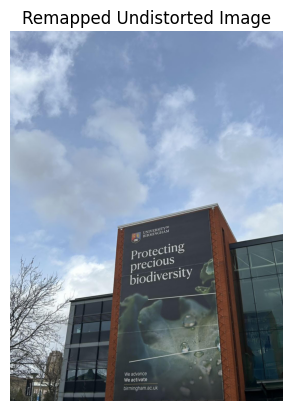

In [8]:
#######################################
# Undistortion using remapping
#######################################
# Compute the undistortion mapping
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w, h), cv.CV_32FC1)
remapped = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

# Crop the image using ROI
x, y, w, h = roi
remapped = remapped[y:y+h, x:x+w]

# Convert to RGB for display
dst_rgb = cv.cvtColor(remapped, cv.COLOR_BGR2RGB)

plt.imshow(dst_rgb)
plt.title('Remapped Undistorted Image')
plt.axis('off')
plt.show()
plt.close('all')

## Re-projection Error
Re-projection error gives a good estimation of just how exact the found parameters are. The closer the re-projection error is to zero, the more accurate the parameters we found are. Given the intrinsic, distortion, rotation and translation matrices, we must first transform the object point to image point using cv.projectPoints(). Then, we can calculate the absolute norm between what we got with our transformation and the corner finding algorithm. To find the average error, we calculate the arithmetical mean of the errors calculated for all the calibration images.

In [9]:
#######################################
# Re-projection Error
#######################################
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
    mean_error += error

mean_error /= len(objpoints)
print("Total re-projection error:", mean_error)

Total re-projection error: 0.07421371464144044


#### 1. What is the goal of camera calibration, and why do we need a sufficient number of correspondences between 3D points and their image projections?

The primary goal of camera calibration is to determine the camera's intrinsic and extrinsic parameters to correct lens distortions and obtain accurate measurements from images. This process allows us to map 3D world coordinates to 2D image coordinates correctly, which is essential for applications such as 3D reconstruction, object tracking, and augmented reality.

A sufficient number of correspondences between 3D object points and their 2D image projections is crucial because:
1. Accurate Estimation
2. Robustness Against Noise
3. Handling Lens Distortion

#### 2. In single-view metrology, how can perspective projection and vanishing lines help us infer scene structure from a single image?

perspective projection and vanishing lines allow us to infer depth, scale, and orientation of objects in a single image without requiring multiple viewpoints or stereo vision.

#### 3. How do reflectance models, such as Lambertian and specular models, affect the interpretation of image intensities in photometric image formation?

Reflectance models are fundamental in photometric image formation. Lambertian models simplify shape interpretation through shading, while specular models introduce directional intensity variations that complicate analysis but provide material cues.